<a href="https://colab.research.google.com/github/rexindustries/HowToLoadPretrainedModels/blob/master/BeansDatasetClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing the libraries and packages
import tensorflow as tf
# import Tensorflow Dataset
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Helper libraries
import math
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Getting the data
dataset, meta_data = tfds.load('beans', as_supervised=True, with_info=True)
train_dataset, test_dataset, validate_dataset = dataset['train'], dataset['test'], dataset['validation']
# There are 3 classes which we have to classify between 2 diseases and the healthy class. Diseases include Angular Leaf Spot and Bean dust

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incompleteFEINUS/beans-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incompleteFEINUS/beans-validation.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incompleteFEINUS/beans-test.tfrecord
Dataset beans downloaded and prepared to /root/tensorflow_datasets/beans/0.1.0. Subsequent calls will reuse this data.


In [3]:
print(meta_data)

tfds.core.DatasetInfo(
    name='beans',
    version=0.1.0,
    description='Beans is a dataset of images of beans taken in the field using smartphone
cameras. It consists of 3 classes: 2 disease classes and the healthy class.
Diseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated
by experts from the National Crops Resources Research Institute (NaCRRI) in
Uganda and collected by the Makerere AI research lab.
',
    homepage='https://github.com/AI-Lab-Makerere/ibean/',
    features=FeaturesDict({
        'image': Image(shape=(500, 500, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=1295,
    splits={
        'test': 128,
        'train': 1034,
        'validation': 133,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {beansdata,
        author="Makerere AI Lab",
        title="Bean disease dataset",
        month="January",
        year="2020",
        url="https://gi

In [4]:
# number of examples in training and testing set
num_train_examples = meta_data.splits['train'].num_examples
num_test_examples = meta_data.splits['test'].num_examples
num_validation_examples = meta_data.splits['validation'].num_examples
print(f'No. of trainig examples -- > {num_train_examples}')
print(f'No. of test examples --> {num_test_examples}')
print(f'No. of validation examples --> {num_validation_examples}')

No. of trainig examples -- > 1034
No. of test examples --> 128
No. of validation examples --> 133


In [5]:
IMAGE_RES = 224
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches = train_dataset.shuffle(num_train_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validate_dataset.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [6]:
# using MobileNet
import tensorflow_hub as hub
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))

In [7]:
feature_extractor.trainable = False

In [8]:
num_classes = meta_data.features['label'].num_classes
model = tf.keras.Sequential([
                             feature_extractor,
                             tf.keras.layers.Dense(num_classes)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [10]:
EPOCHS = 100
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches,
                    callbacks=[callback]
                    )

Epoch 1/100
33/33 [==============================] - 5s 146ms/step - loss: 0.8449 - accuracy: 0.5948 - val_loss: 0.5587 - val_accuracy: 0.7970
Epoch 2/100
33/33 [==============================] - 3s 84ms/step - loss: 0.4652 - accuracy: 0.8191 - val_loss: 0.4255 - val_accuracy: 0.8421
Epoch 3/100
33/33 [==============================] - 3s 86ms/step - loss: 0.3677 - accuracy: 0.8598 - val_loss: 0.3634 - val_accuracy: 0.8872
Epoch 4/100
33/33 [==============================] - 3s 85ms/step - loss: 0.3084 - accuracy: 0.8956 - val_loss: 0.3284 - val_accuracy: 0.8947
Epoch 5/100
33/33 [==============================] - 3s 85ms/step - loss: 0.2735 - accuracy: 0.9110 - val_loss: 0.3088 - val_accuracy: 0.9173
Epoch 6/100
33/33 [==============================] - 3s 86ms/step - loss: 0.2439 - accuracy: 0.9226 - val_loss: 0.2864 - val_accuracy: 0.9023
Epoch 7/100
33/33 [==============================] - 3s 85ms/step - loss: 0.2174 - accuracy: 0.9352 - val_loss: 0.2724 - val_accuracy: 0.9248
Epoch

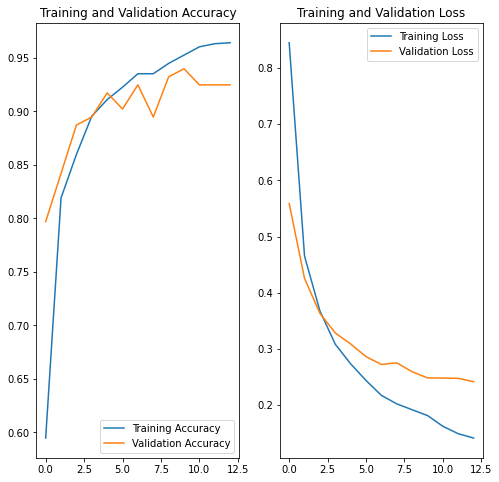

In [12]:
EPOCHS = 13 # obtained from early stopping
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [13]:
class_names = np.array(meta_data.features['label'].names)

print(class_names)

['angular_leaf_spot' 'bean_rust' 'healthy']


In [14]:
image_batch, label_batch = next(iter(train_batches))

image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

print(predicted_class_names)

['bean_rust' 'angular_leaf_spot' 'healthy' 'angular_leaf_spot' 'bean_rust'
 'healthy' 'healthy' 'angular_leaf_spot' 'bean_rust' 'healthy' 'bean_rust'
 'bean_rust' 'angular_leaf_spot' 'bean_rust' 'angular_leaf_spot'
 'bean_rust' 'healthy' 'angular_leaf_spot' 'healthy' 'healthy' 'bean_rust'
 'bean_rust' 'bean_rust' 'healthy' 'healthy' 'bean_rust'
 'angular_leaf_spot' 'healthy' 'healthy' 'healthy' 'angular_leaf_spot'
 'angular_leaf_spot']


In [15]:
print("Labels:        ", label_batch)
print("Predicted Labels:   ", predicted_ids)

Labels:         [0 0 2 0 1 2 2 0 1 2 1 1 0 1 0 1 2 0 2 2 1 1 1 2 2 1 0 2 2 2 0 0]
Predicted Labels:    [1 0 2 0 1 2 2 0 1 2 1 1 0 1 0 1 2 0 2 2 1 1 1 2 2 1 0 2 2 2 0 0]


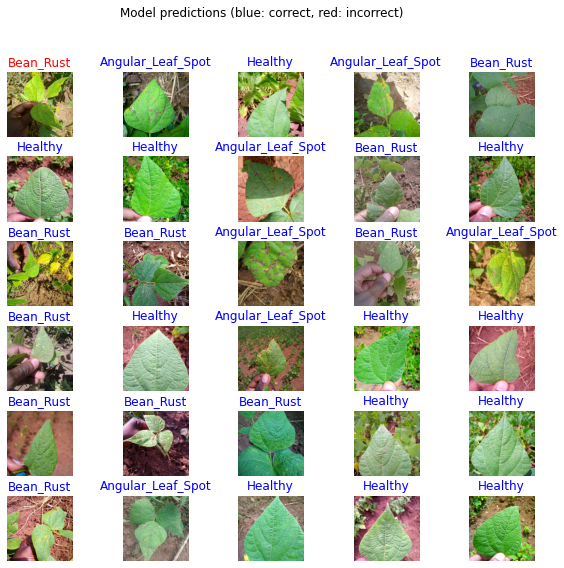

In [16]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

In [17]:
# prediciton on test
test_batches = test_dataset.map(format_image).batch(BATCH_SIZE).prefetch(1)


In [18]:
model.evaluate(test_batches)

4/4 [==============================] - 0s 83ms/step - loss: 0.2414 - accuracy: 0.8906


[0.24143238365650177, 0.890625]

In [19]:
# for test batches
image_batch, label_batch = next(iter(test_batches))

image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

print(predicted_class_names)

['angular_leaf_spot' 'bean_rust' 'bean_rust' 'healthy' 'healthy'
 'angular_leaf_spot' 'bean_rust' 'angular_leaf_spot' 'angular_leaf_spot'
 'bean_rust' 'angular_leaf_spot' 'angular_leaf_spot' 'bean_rust' 'healthy'
 'healthy' 'healthy' 'angular_leaf_spot' 'angular_leaf_spot' 'healthy'
 'healthy' 'bean_rust' 'angular_leaf_spot' 'healthy' 'healthy' 'healthy'
 'healthy' 'angular_leaf_spot' 'bean_rust' 'bean_rust' 'healthy'
 'bean_rust' 'healthy']


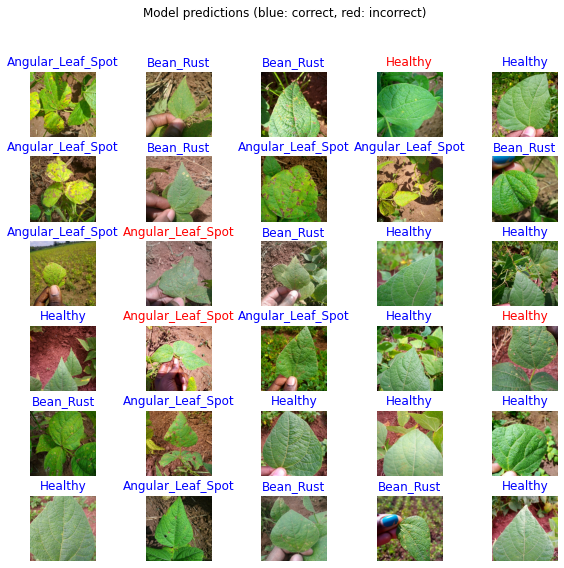

In [20]:
# test set predictions plot
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")